In [1]:
import sys
sys.path.append("..")

import torch
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange
from tqdm import tqdm, trange
from torch.nn import functional as F
from utils.download_mnist import mnist_dataloader_test
from assembler import get_config, get_config_ebm, make_energy_model
from utils.config import show 

path = !cd .. && pwd
path = path[0]

def plotable(img):
    return rearrange(img, "b c h w -> (b c h) w ").cpu().detach().numpy()

def get_model_config(model_name):
    dataset, model, sampling, task = model_name.split("/")
    name = f"{sampling}/{task}"
    config = get_config(get_config_ebm, dataset, model, name, path=path)
    return config

def reconstruction_error(x_hat, x, reduction="mean"):
    return F.mse_loss(x_hat, x, reduction=reduction)

def experiment(config, x):
    ebm = make_energy_model(config, path=path)
    
    # The math
    x_tilde = ebm.operator(x)
    x_hat = ebm(x_tilde)
    
    # The result
    fig, axs = plt.subplots(nrows = 1, ncols = 2)
    axs[0].set_title("original")
    axs[0].imshow(plotable(x))
    axs[1].set_title("estimation")
    axs[1].imshow(plotable(x_hat))
    plt.show()

In [2]:
model_name = "mnist/vae/langevin/inpainting2"
config = get_model_config(model_name)
dm = mnist_dataloader_test(config, path=path)
gen = iter(dm)
x, y = next(gen)

/home/mingliang/anaconda3/envs/torch3090/lib/python3.7/site-packages/torchvision/datasets/mnist.py:498: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1623448265233/work/torch/csrc/utils/tensor_numpy.cpp:180.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


In [3]:
config["operator_params"]["operator"] = "CenterOcclude"
config["operator_params"]["num_measurements"] = 200
config["estimator_params"]["initalisation"] = "map_posterior"
config["estimator_params"]["num_steps_map_initaliser"] = 1
config["estimator_params"]["step_size_map_initaliser"] = 0.1

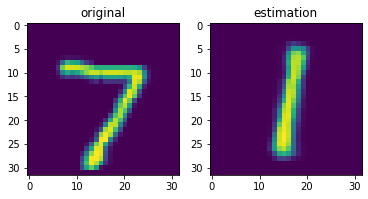

In [4]:
experiment(config, x)

In [5]:
ebm = make_energy_model(config, path=path)
    
# The math
x_tilde = ebm.operator(x)
x_hat = ebm(x_tilde)

In [6]:
x_tilde.shape

torch.Size([1, 1, 32, 32])

In [7]:
from numpy import exp,arange, meshgrid
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
@np.vectorize
def z_func(x,y):
 return ebm.energy_fn(x_tilde)(torch.tensor([[x,y]], dtype=torch.float32)).detach().numpy()

In [8]:
x_ = arange(-5.0,5.0,0.1)
y_ = arange(-5.0,5.0,0.1)
X,Y = meshgrid(x_, y_) # grid of point
Z = z_func(X, Y) # evaluation of the function on the grid

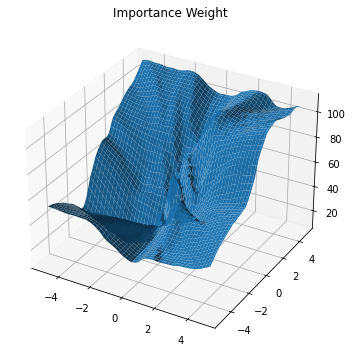

In [9]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')


# Plot a 3D surface
ax.plot_surface(X, Y, Z)

title('Importance Weight')
show()

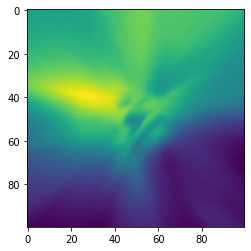

In [10]:
im = imshow(-Z)

In [11]:
config['estimator_params']['potential'] = "discriminator_weighted"
config['estimator_params']['discriminator_base_model'] = "mnist/gan/dcgan"

In [12]:
ebm2 = make_energy_model(config, path=path)
    
# The math
x_tilde = ebm2.operator(x)
x_hat = ebm2(x_tilde)

In [13]:
from numpy import exp,arange, meshgrid
from pylab import meshgrid,cm,imshow,contour,clabel,colorbar,axis,title,show

# the function that I'm going to plot
@np.vectorize
def z2_func(x,y):
 return ebm2.energy_fn(x_tilde)(torch.tensor([[x,y]], dtype=torch.float32)).detach().numpy()

In [14]:
x2_ = arange(-5.0,5.0,0.1)
y2_ = arange(-5.0,5.0,0.1)
X2,Y2 = meshgrid(x_, y_) # grid of point
Z2 = z2_func(X2, Y2) # evaluation of the function on the grid

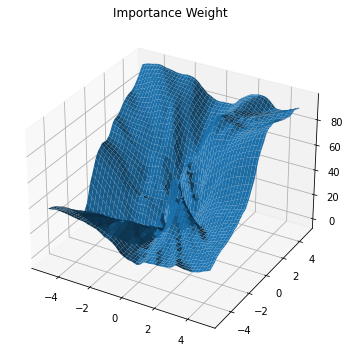

In [15]:
fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, projection='3d')


# Plot a 3D surface
ax.plot_surface(X2, Y2, Z2)

title('Importance Weight')
show()

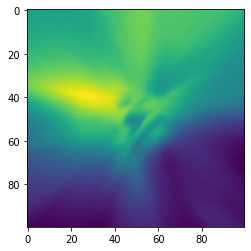

In [16]:
im = imshow(-Z)

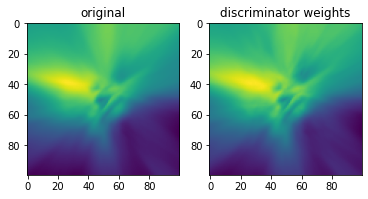

In [17]:
fig, axs = plt.subplots(nrows = 1, ncols = 2)
axs[0].set_title("original")
axs[0].imshow(-Z)
axs[1].set_title("discriminator weights")
axs[1].imshow(-Z2)
plt.show()